
# Сервис для полуавтоматической разметки товаров

**Цель проекта:**

Разработка решения, которое отчасти автоматизирует процесс сопоставления товаров. Основная идея - предлагать несколько товаров заказчика, которые с наибольшей вероятностью соответствуют размечаемому товару дилера. 
Предлагается реализовать это решение, как онлайн сервис, открываемый в веб-браузере. Выбор наиболее вероятных подсказок делается методами машинного обучения.


## Описание данных
Заказчик предоставил несколько таблиц (дамп БД), содержащих необходимые данные:

1. `marketing_dealer` - список дилеров


2.	`marketing_dealerprice` - результат работы парсера площадок дилеров:
    - `product_key` - уникальный номер позиции;
    -	`price` - цена;
    -	`product_url` - адрес страницы, откуда собраны данные;
    -	`product_name` - заголовок продаваемого товара;
    -	`date` - дата получения информации;
    -	`dealer_id` - идентификатор дилера (внешний ключ к marketing_dealer)
    

3.	`marketing_product` - список товаров, которые производит и распространяет заказчик:
    - `article` - артикул товара;
    -	`ean_13` - код товара (см. EAN 13)
    -	`name` - название товара;
    -	`cost` - стоимость;
    -	`min_recommended_price` - рекомендованная минимальная цена;
    -	`recommended_price` - рекомендованная цена;
    -	`category_id` - категория товара;
    -	`ozon_name` - названиет товара на Озоне;
    -	`name_1c` - название товара в 1C;
    -	`wb_name` - название товара на Wildberries;
    -	`ozon_article` - описание для Озон;
    -	`wb_article` - артикул для Wildberries;
    -	`ym_article` - артикул для Яндекс.Маркета


4.	`marketing_productdealerkey` - таблица матчинга товаров заказчика и товаров дилеров:
    -	`key` - внешний ключ к marketing_dealerprice
    -	`product_id` - внешний ключ к marketing_product
    -	`dealer_id` - внешний ключ к marketing_dealer


## Импорт

In [ ]:
# requirments.txt
# pandas==2.0.0 
# numpy==1.23.5 
# seaborn==0.11.1 
# phik==0.10.0 
# sklearn==1.2.2 
# statsmodels==0.13.2 
# lightgbm==3.3.5 
# joblib==1.2.0 
# matplotlib==3.7.1 
# nltk==3.8.1
# sentence_transformers
# tqdm

In [1]:
# импорт необходимых библиотек


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tqdm.pandas() # для работы progress_apply в пандас

from sentence_transformers import SentenceTransformer, util
from concurrent import futures
from tqdm import tqdm

# from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
# from sklearn.pipeline import Pipeline
# import phik
# from scipy import stats as st
# from lightgbm import LGBMRegressor, plot_importance
# from sklearn.compose import ColumnTransformer
# import joblib
# import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
# pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_colwidth', None)
sns.set(rc={'figure.figsize':(18,8)}, style="darkgrid")

## Загрузка и знакомство с данными

In [3]:
DATA_DIR = 'data/'
try:
    dealers_id = pd.read_csv(DATA_DIR + 'marketing_dealer.csv', sep=";")
    data_dealers = pd.read_csv(DATA_DIR +'marketing_dealerprice.csv', sep=";", parse_dates=['date'])
    data_products = pd.read_csv(DATA_DIR + 'marketing_product.csv', sep=";", index_col='Unnamed: 0',)
    data_key = pd.read_csv(DATA_DIR + 'marketing_productdealerkey.csv',  sep=";")
    
except:
    delers_id = pd.read_csv('marketing_dealer.csv', sep=";")
    data_dealers = pd.read_csv('marketing_dealerprice.csv', sep=";", parse_dates=['date'])
    data_products = pd.read_csv('marketing_product.csv', sep=";", index_col='Unnamed: 0',)
    data_key  = pd.read_csv('marketing_productdealerkey.csv', sep=';')

In [7]:
dealers_id

,id,name
0,1,Moi_vibor_WB
1,2,Akson
2,3,Bafus
3,5,Castorama
4,6,Cubatora
5,7,Komus
6,9,Megastroy
7,10,OnlineTrade
8,11,Petrovich
9,12,sdvor


В наших данных должно быть не более 18 диллеров заказчиков, id которых пронумерованы последовательно

In [6]:

display(data_dealers.head(), 
        data_dealers.shape, 
        data_dealers.info(), 
        data_dealers.describe(include='all').T,
        data_dealers.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20416 entries, 0 to 20415
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            20416 non-null  int64         
 1   product_key   20416 non-null  object        
 2   price         20416 non-null  float64       
 3   product_url   20182 non-null  object        
 4   product_name  20416 non-null  object        
 5   date          20416 non-null  datetime64[ns]
 6   dealer_id     20416 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 1.1+ MB


,id,product_key,price,product_url,product_name,date,dealer_id
0,2,546227,233.0,https://akson.ru//p/sredstvo_universalnoe_prosept_universal_spray_500ml/,"Средство универсальное Prosept Universal Spray, 500мл",2023-07-11,2
1,3,546408,175.0,https://akson.ru//p/kontsentrat_prosept_multipower_dlya_mytya_polov_tsitrus_1l/,"Концентрат Prosept Multipower для мытья полов, цитрус 1л",2023-07-11,2
2,4,546234,285.0,https://akson.ru//p/sredstvo_dlya_chistki_lyustr_prosept_universal_anti_dust_500ml/,"Средство для чистки люстр Prosept Universal Anti-dust, 500мл",2023-07-11,2
3,5,651258,362.0,https://akson.ru//p/udalitel_rzhavchiny_prosept_rust_remover_0_5l_023_05/,"Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 023-05",2023-07-11,2
4,6,546355,205.0,https://akson.ru//p/sredstvo_moyushchee_dlya_bani_i_sauny_prosept_multipower_wood_1l/,Средство моющее для бани и сауны Prosept Multipower Wood 1л,2023-07-11,2


(20416, 7)

None

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
id,20416.0,NaN,NaN,NaN,10350.362363,2.0,5257.75,10361.5,15465.25,20570.0,5912.127932
product_key,20416,1965,44232019,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,20416.0,NaN,NaN,NaN,1257.323521,0.0,308.0,613.0,1207.0,34500.0,2090.632753
product_url,20182,1883,https://api.ozon.ru/composer-api.bx/page/json/v2?url=/seller/552340/products/?brand=140367694&layout_container=default&layout_page_index=4&miniapp=seller_552340&page=3&sold_out_page=1,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,20416,1953,Просепт Bio Lasur антисептик лессирующий защитно-декоративный (900 мл),117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date,20416,NaN,NaN,NaN,2023-07-19 20:58:52.288401152,2023-07-11 00:00:00,2023-07-13 00:00:00,2023-07-19 00:00:00,2023-07-26 00:00:00,2023-07-31 00:00:00,NaN
dealer_id,20416.0,NaN,NaN,NaN,8.938627,1.0,3.0,9.0,15.0,18.0,5.72333


0

- 20416 записей
- product_key в object, необходимо будет проверить все ли записи содержат только цифры
- цена есть 0 и проверить самую большую 34500 - может куб?
- полных дубликатов нет

In [7]:
display(data_products.head(), 
        data_products.shape, 
        data_products.info(), 
        data_products.describe(include='all').T,
        data_products.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Index: 496 entries, 0 to 495
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 496 non-null    int64  
 1   article            496 non-null    object 
 2   ean_13             464 non-null    float64
 3   name               494 non-null    object 
 4   cost               491 non-null    float64
 5   recommended_price  491 non-null    float64
 6   category_id        447 non-null    float64
 7   ozon_name          458 non-null    object 
 8   name_1c            485 non-null    object 
 9   wb_name            455 non-null    object 
 10  ozon_article       365 non-null    float64
 11  wb_article         340 non-null    float64
 12  ym_article         337 non-null    object 
 13  wb_article_td      32 non-null     object 
dtypes: float64(6), int64(1), object(7)
memory usage: 58.1+ KB


,id,article,ean_13,name,cost,recommended_price,category_id,ozon_name,name_1c,wb_name,ozon_article,wb_article,ym_article,wb_article_td
0,245,008-1,4.680008e+12,Антисептик невымываемыйPROSEPT ULTRAконцентрат 1:10 / 1 л,360.00,858.0,20.0,"Антисептик невымываемый для ответственных конструкций PROSEPT ULTRA, концентрат, 1 л.","Антисептик невымываемый для ответственных конструкций PROSEPT ULTRA, концентрат, 1 л.","Антисептик невымываемый для ответственных конструкций PROSEPT ULTRA, концентрат, 1 л.",189522705.0,150033482.0,008-1,NaN
1,3,242-12,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,460.16,1075.0,NaN,NaN,Антигололед - 32 PROSEPTготовый состав / 12 кг,NaN,NaN,NaN,NaN,NaN
2,443,0024-06 с,4.680008e+12,"Герметик акриловый цвет сосна, ф/п 600мл",307.00,644.0,25.0,"Герметик акриловый для швов для деревянных домов, конструкций, изделий PROSEPT цвет сосна, ф/п 600мл","Герметик акриловый цвет сосна, ф/п 600мл","Герметик акриловый для швов для деревянных домов, конструкций, изделий PROSEPT цвет сосна, ф/п 600мл",189522735.0,150126217.0,0024-06-с,NaN
3,147,305-2,4.610093e+12,Кондиционер для белья с ароматом королевского ИрисаCrystal Rinserконцентрат / 2 л,157.73,342.0,29.0,"Кондиционер для белья ""Королевский Ирис"" Prosept Crystal Rinser, 2 л.","Кондиционер для белья ""Королевский Ирис"" Prosept Crystal Rinser, 2 л.","Кондиционер для белья ""Королевский Ирис"" Prosept Crystal Rinser, 2 л.",339377922.0,150032962.0,305-2,NaN
4,502,0024-7 б,NaN,"Герметик акриловой цвет Белый, 7 кг",NaN,NaN,NaN,NaN,NaN,NaN,189522867.0,150126216.0,0024-7-б,NaN


(496, 14)

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,496.0,NaN,NaN,NaN,251.320565,147.092825,1.0,124.75,248.5,377.25,513.0
article,496,496,008-1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ean_13,464.0,NaN,NaN,NaN,4667049822645.542969,27196558445.528442,4610093420010.0,4680008140430.25,4680008144209.5,4680008147203.5,4680008149985.0
name,494,487,"Герметик акриловый цвет Орех, 3 кг",2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cost,491.0,NaN,NaN,NaN,880.162709,1245.260825,44.0,201.0,409.0,839.5,8011.0
recommended_price,491.0,NaN,NaN,NaN,1880.37279,2518.474824,0.0,436.0,891.0,1799.5,14980.0
category_id,447.0,NaN,NaN,NaN,34.342282,10.584979,20.0,25.0,33.0,41.0,57.0
ozon_name,458,454,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
name_1c,485,473,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wb_name,455,451,"Грунт влагоизолирующий PROSEPT Акваизол, 3 л.",3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


0

In [8]:
# уникальных значений id
len(data_products['id'].unique())

496

- wb_article_td - что за признак? соединить с wb_article?
- есть 0 в рекомендованной цене
- немного пропусков в характеристиках
- много пропусков в артикулах для маркетплейсов. При этом название название товара для маркетплейса есть. Предположим, что пропуски это товары, которые на них не продаются
- уникальных значений id 496 в диапазоне 1 - 513
- category_id  целое число от 20 до 57, можно поробовать восстановить
- явных строк-дубликатов нет

In [9]:
# рекомендуемая цена равна нулю
# data_products[data_products['recommended_price']==0]

In [10]:
# пропуски в цене
# data_products[data_products['cost'].isna()]

In [11]:
# пропуски в категорим
# data_products[data_products['category_id'].isna()]

In [16]:
display(data_key.head(), data_key.shape, data_key.info(), data_key.describe(include='all').T,
       data_key.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1700 entries, 0 to 1699
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1700 non-null   int64 
 1   key         1700 non-null   object
 2   dealer_id   1700 non-null   int64 
 3   product_id  1700 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 53.2+ KB


,id,key,dealer_id,product_id
0,1,546227,2,12
1,2,651265,2,106
2,3,546257,2,200
3,4,546408,2,38
4,5,651258,2,403


(1700, 4)

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1700.0,NaN,NaN,NaN,1063.140588,615.283828,1.0,425.75,1173.5,1598.25,2023.0
key,1700,1700,546227,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dealer_id,1700.0,NaN,NaN,NaN,10.148824,5.830717,1.0,3.0,10.0,15.0,18.0
product_id,1700.0,NaN,NaN,NaN,223.564118,132.341778,1.0,110.0,239.5,334.25,479.0


0

- 1700 уникальных значений ключей для дилер-продукт, это какие продукты у каких диллеров продаются?
    - в таблице с инфо от диллеров всего 1965 уникальных ключей
    - в таблице с продуктами производителя 496 уникальных id товаров
- признак key опять имеет строковый тип данных, далее проверим
- дубликатов нет


In [13]:
data_key['product_id'].describe()

count    1700.000000
mean      223.564118
std       132.341778
min         1.000000
25%       110.000000
50%       239.500000
75%       334.250000
max       479.000000
Name: product_id, dtype: float64

In [5]:
# key имеет формат object, проверим все ли знаки в ключах являются цифрами
contains_non_digits = data_key['key'].apply(lambda x: any(c.isalpha() for c in x))
data_key[contains_non_digits]


,id,key,dealer_id,product_id
431,739,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/sprey_dlya_ochistki_polkov_v_banyakh_i_saunakh_universal_wood_0_5l/,6,20
432,740,https://kub02.ru/catalog/prosept/antiseptik_universalnyy_dlya_vnutr_i_naruzhn_prosept_universal_1l/,6,259
433,741,https://kub02.ru/catalog/prosept/antiseptik_nevymyvaemyy_korichnevyy_prosept_ultra_kontsentrat_1_10_1l/,6,249
434,742,https://kub02.ru/catalog/prosept/lak_dlya_bani_i_sauny_termostoykiy_akrilovyy_prosept_0_9l/,6,321
435,743,https://kub02.ru/catalog/prosept/antiseptik_nevymyvaemyy_korichnevyy_prosept_eco_ultra_gotovyy_sostav_5l/,6,275
436,744,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_tsementa_prosept_cement_cleaner_1l/,6,401
437,745,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/universalnyy_pyatnovyvoditel_prosept_candy_0_5l/,6,162
438,746,https://kub02.ru/catalog/prosept/antiseptik_nevymyvaemyy_korichnevyy_prosept_ultra_kontsentrat_1_10_5l/,6,250
439,747,https://kub02.ru/catalog/prosept/maslo_dlya_zashchity_polkov_prosept_sauna_oil_gotovyy_sostav_0_25l/,6,320
440,748,https://kub02.ru/catalog/prosept/otbelivatel_dlya_drevesiny_prosept_50_1_1_1l/,6,240


In [6]:
# аналогичная проверка в таблице от диллеров
contains_non_digits2 = data_dealers['product_key'].apply(lambda x: any(c.isalpha() for c in x))
data_dealers[contains_non_digits2]

,id,product_key,price,product_url,product_name,date,dealer_id
703,700,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/sprey_dlya_ochistki_polkov_v_banyakh_i_saunakh_universal_wood_0_5l/,297.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/sprey_dlya_ochistki_polkov_v_banyakh_i_saunakh_universal_wood_0_5l/,"Спрей для очистки полков в банях и саунах Universal Wood, 0,5л",2023-07-11,6
704,701,https://kub02.ru/catalog/prosept/antiseptik_universalnyy_dlya_vnutr_i_naruzhn_prosept_universal_1l/,748.0,https://kub02.ru/catalog/prosept/antiseptik_universalnyy_dlya_vnutr_i_naruzhn_prosept_universal_1l/,"Антисептик универсальный для внутр. и наружн. PROSEPT UNIVERSAL, 1Л",2023-07-11,6
705,702,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_vysolov_prosept_salt_cleaner_1l_sostav_1_2/,613.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_vysolov_prosept_salt_cleaner_1l_sostav_1_2/,Удалитель высолов PROSEPT SALT CLEANER (1л) состав 1:2,2023-07-11,6
706,703,https://kub02.ru/catalog/kraska_i_gruntovka/kraska_grunt_fasadnaya_dlya_plit_osb_proff_3v1_1kg_prosept/,487.0,https://kub02.ru/catalog/kraska_i_gruntovka/kraska_grunt_fasadnaya_dlya_plit_osb_proff_3v1_1kg_prosept/,Краска-грунт фасадная для плит OSB Proff 3в1 (1кг) PROSEPT,2023-07-11,6
707,704,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_tsementa_prosept_cement_cleaner_1l/,569.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_tsementa_prosept_cement_cleaner_1l/,"Удалитель цемента PROSEPT CEMENT CLEANER ,1Л",2023-07-11,6
...,...,...,...,...,...,...,...
19195,19345,https://kub02.ru/catalog/prosept/antiseptik_dlya_bani_i_sauny_prosept_sauna_1_10_1l/,755.0,https://kub02.ru/catalog/prosept/antiseptik_dlya_bani_i_sauny_prosept_sauna_1_10_1l/,"Антисептик для бани и сауны PROSEPT SAUNA 1:10, 1л",2023-07-31,6
19196,19346,https://kub02.ru/catalog/prosept/ognebiozashchita_dlya_drevesiny_prosept_2_gruppa_s_indikatorom_gotovyy_sostav_10_kg/,888.0,https://kub02.ru/catalog/prosept/ognebiozashchita_dlya_drevesiny_prosept_2_gruppa_s_indikatorom_gotovyy_sostav_10_kg/,"Огнебиозащита для древесины PROSEPT, 2 группа с индикатором, готовый состав, 10 кг",2023-07-31,6
19197,19347,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_rzhavchiny_prosept_rust_remover_gotovyy_sostav_0_5l/,396.0,https://kub02.ru/catalog/professionalnaya_bytovaya_khimiya/udalitel_rzhavchiny_prosept_rust_remover_gotovyy_sostav_0_5l/,"Удалитель ржавчины PROSEPT RUST REMOVER готовый состав 0,5Л",2023-07-31,6
19198,19348,https://kub02.ru/catalog/emali/propitka_dlya_kamnya_gidrofobiziruyushchiy_sostav_1l_prosept_aquaisol_sostav_1_2_/,406.0,https://kub02.ru/catalog/emali/propitka_dlya_kamnya_gidrofobiziruyushchiy_sostav_1l_prosept_aquaisol_sostav_1_2_/,Пропитка для камня гидрофобизирующий состав (1л) PROSEPT AQUAISOL состав 1:2,2023-07-31,6


Вместо численных ключей у нескольких продуктов указано url в обеих таблицах. Оставляем, так как по ним соединяются таблицы без проблем

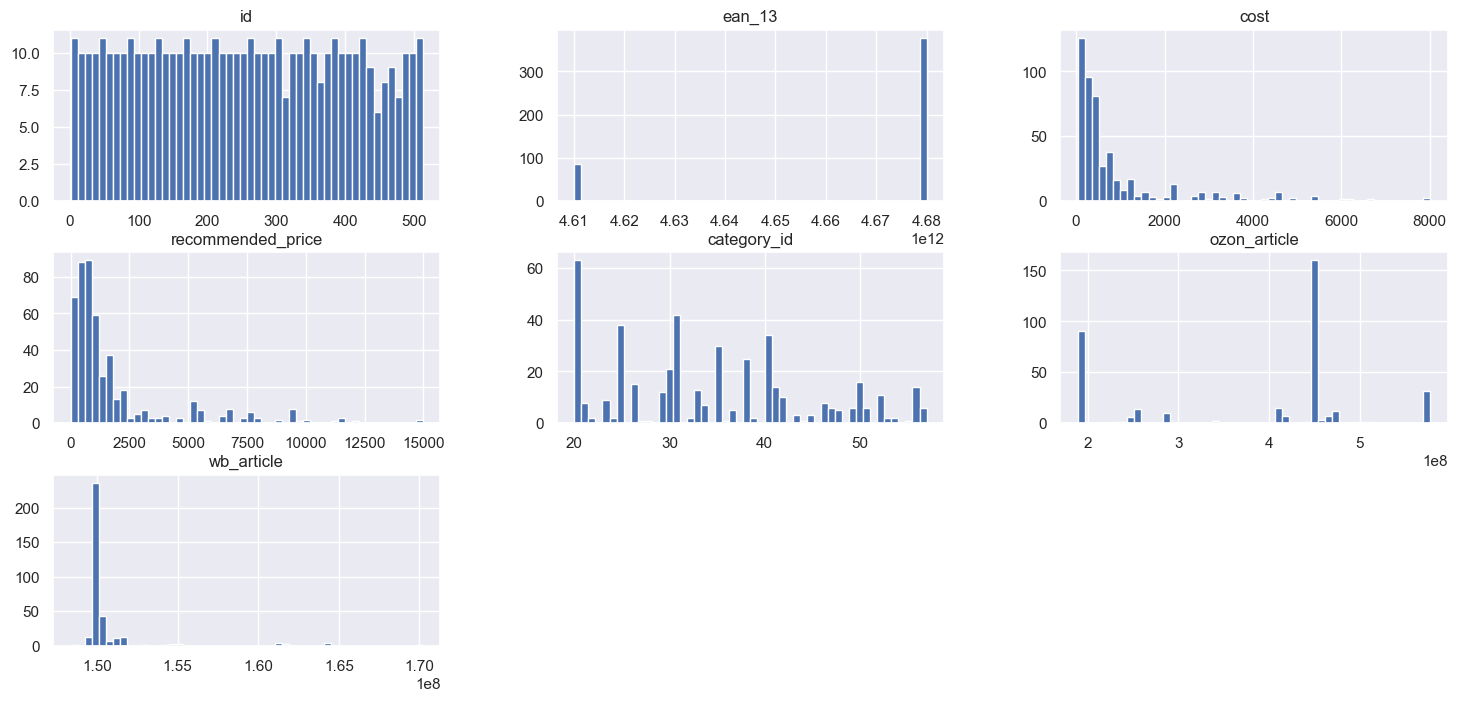

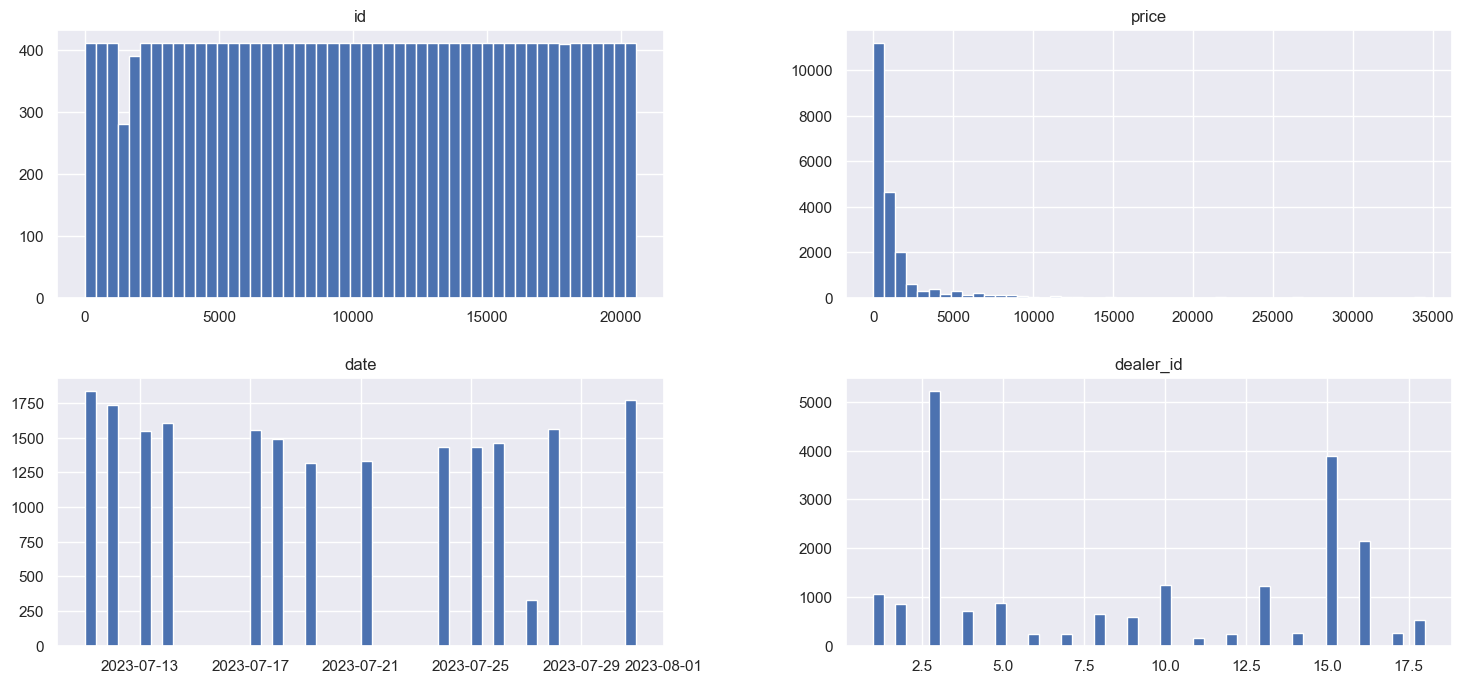

In [16]:
data_products.hist(bins=50);
data_dealers.hist(bins=50);

## Подготовка данных

In [14]:
# Функция для добавления пропущенных пробелов в наименованиях.
def add_spaces(text):
    spaced_text = re.sub(r'(?<=[a-zA-Z])(?=[а-яА-ЯёЁ])|(?<=[а-яА-ЯёЁ])(?=[a-zA-Z])', ' ', text)
    spaced_text = re.sub(r'(\S)\*(\S)', r'\1 * \2', spaced_text)
    spaced_text = re.sub(r'(\d+)([а-яА-ЯёЁa-zA-Z]+)', r'\1 \2', spaced_text)
    return spaced_text


# Функция для извлечения концентрации, объема, единицы измерения и фасовки из наименования товара в отдельные столбцы.
def extract_info(data):
    pattern_volume = r'\s*(\d+(?:[.,]\d+)?)\s*([мк]?[лг]|лит[р]?[ы]?|к[г]?[р]?[ам]?[ы]?)\s*'
    pattern_concentration = r'\s*(\d+:\d+)\s*'
    pattern_quantity = r'\s*(\d+)\s*(?:шт(?:ук[и]?|\.)?|ШТ|шт)\s*'

    data['volume'] = data['name'].str.extract(pattern_volume, expand=True)[0]
    data['units_of_meas'] = data['name'].str.extract(pattern_volume, expand=True)[1]
    data['concent'] = data['name'].str.extract(pattern_concentration, expand=False)
    data['units'] = data['name'].str.extract(pattern_quantity, expand=False)
    
    data['units'].fillna('1', inplace=True)
    data['concent'].fillna('1:1', inplace=True)
    data['volume'].fillna('1', inplace=True)
    data['units_of_meas'].fillna('шт', inplace=True)
    
    # Добавляем ваш фрагмент кода для удаления лишних пробелов между буквой и словом
    data['name'] = data['name'].str.replace(r'(\w)\s+(?=\w)', r'\1')

    return data


# Функция для извлечения первых 3-4 слов из названия товара
def extract_keywords(name):
    words = name.split()[:4]
    return ' '.join(words)


# Функция очистки,  токенизации, лемматизации и удаление стоп-слов.
def preprocess_text(text):
    # Очистка текста
    cleaned_text = re.sub(r"[^a-zA-Zа-яА-ЯёЁ ]", ' ', text)
    
    # Токенизация
    tokens = word_tokenize(cleaned_text.lower())
    
    # Лемматизация
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Удаление стоп-слов
    stop_words = set(stopwords.words('russian') + stopwords.words('english'))
    filtered_words = [lemma for lemma in lemmas if lemma not in stop_words]
    
    # Возвращение предобработанного текста
    return ' '.join(filtered_words)

### Обработка признаков с текстовыми названиями

In [15]:
# удалилли пропуск в названии 2 шт
data_products.dropna(subset=['name'], inplace=True)
# удалили одно название пустое
empty_name_rows = data_products[data_products['name'].str.contains(r'^\s*$')]
data_products.drop(index=empty_name_rows.index, inplace=True)

In [16]:
#  добавить пропущенные пробелы в наименования товаров в столбцах 'name', 'name_1c', 'ozon_name' и 'wb_name'
columns_to_apply = ['name', 'name_1c', 'ozon_name', 'wb_name']
data_products[columns_to_apply] = data_products[columns_to_apply].astype(str).applymap(add_spaces)

In [17]:
#  обьем, количество штук в упаковке, концентрация продукция, разная единица измерения
# извлечь и зафиксировать в отдельные столбцы в качестве дополнительных признаков
data_products = extract_info(data_products)

In [18]:
# обнаружено, что есть лишний пробел в слове Средство "C редство"
# вручную исправим ошибку
data_products['ozon_name'] = data_products['ozon_name'].str.replace('C редство', 'Средство')
data_products['name_1c'] = data_products['name_1c'].str.replace('C редство', 'Средство')
data_products['wb_name'] = data_products['wb_name'].str.replace('C редство', 'Средство')
data_products['name'] = data_products['name'].str.replace('C редство', 'Средство')

In [19]:
# в наименования оказались еще места, которые не были обработаны функцией и уберем эти проблемы вручную
data_products['name'] = data_products['name'].str.replace('БЕТОНКОНТАКТготовый', 'БЕТОНКОНТАКТ готовый')
data_products['name'] = data_products['name'].str.replace('"к', '" к')
data_products['name'] = data_products['name'].str.replace('яблокаконцентрированное', 'яблока концентрированное')
data_products['name'] = data_products['name'].str.replace('(сухой остаток 20%)', ' (сухой остаток 20%) ')
data_products['name'] = data_products['name'].str.replace('.C', '. C')

### Обработка пропусков в остальных признаках

In [20]:
# Заполнение пропущенных значений в категориях на основе группировки по первым 3-4 словам в названиях товаров
data_products['category_id'].fillna(data_products['name'].apply(extract_keywords), inplace=True)

In [21]:
# Для пропусков в ценах поставим просто заглушку -1
data_products['cost'].fillna('-1', inplace=True)
data_products['recommended_price'].fillna('-1', inplace=True)

In [22]:
(data_products.isna().sum() / len(data_products)).to_frame().style.background_gradient()

,0
id,0.000000
article,0.000000
ean_13,0.060852
name,0.000000
cost,0.000000
recommended_price,0.000000
category_id,0.000000
ozon_name,0.000000
name_1c,0.000000
wb_name,0.000000


In [23]:
# векторизация названий в data_products, data_dealers

# Список наименований товаров из таблицы data_products
product_names = data_products['name'].tolist()

# Предобработка наименований товаров
preprocessed_names = [preprocess_text(name) for name in product_names]

# Преобразование векторизации
vectorizer = TfidfVectorizer()
vectorized_names = vectorizer.fit_transform(preprocessed_names).toarray()

# Применение векторизации к таблице data_products
data_products['vectorized_name'] = list(vectorized_names)

# Применение векторизации к таблице data_dealers
data_dealers['vectorized_name'] = list(
        vectorizer.transform(
            data_dealers['product_name'].apply(preprocess_text)
                            ).toarray()
)

## Объединение таблиц

In [24]:
# пока оставляем только признаки с названиями 
# соединим ключи по id с названиями производителя
product_with_key_data = data_key[['key', 'product_id']].merge(data_products[['id', 'name']], 
                                       how='left', 
                                       right_on='id', 
                                       left_on='product_id')
# к датасету с названиями диллеров присоединим наззвания производителя 
full_data = data_dealers[['product_key', 'product_name']].merge( product_with_key_data, 
                               how='left', 
                               right_on='key', 
                               left_on='product_key').drop(['product_id', 'product_key'], axis=1)
full_data.sample(2)

,product_name,key,id,name
1756,Средство для чистки акриловых поверхностей Prosept Bath Acryl 1 л,90162795,63.0,Средство для чистки акриловых поверхностей Bath Acryl концентрат 1:30-1:80 / 1 л
14934,Очиститель фасадов Prosept Salt Cleaner концентрат 1:2 1л,26391298,398.0,Очиститель фасадов SALT CLEANER концентрат 1:2 / 1 л


In [25]:
# full_data.isna().sum()

In [26]:
# full_data[full_data['key'].isna()]

In [27]:
# # уникальных ключей, не указанных в номенклатуре производителя
# dealers = set([x for x in data_dealers['product_key']])
# products = set([x for x in data_key['key']])
# print('Ключи из таблицы спарсенных данных, которых нет в таблице ключей: ', len(dealers - products))

In [28]:
# поиск по словам в названии 
# data_products[data_products['name'].str.contains('Cooky Splash Soft', case=False, na=False)]


В объединённом датасете 2849 строк с пропуском в таргете  - это  363 значения ключей, которые встречаются в датасете с парсингом сайтов диллеров, но отсутствуют в датасете с ключами, следоваттельно, в датасете с продуктами производителя.
При этом есть ключи в data_key, которые не задействованы в data_dealers

То есть у нас 2849 строк без разметки, потенциально 363 продукта, отсутствующих в списке продуктов производителя

Просмотрела, что в неразмеченных продуктах. Похоже, это просто неразмеченные записи. Есть несколько с припиской "Уцененный товар".

In [29]:
#  удалим неразмеченные записи и перезапишем индексы
full_data = full_data.dropna().reset_index(drop=True)
# data_products = data_products.dropna( subset=['name']).reset_index(drop=True)

In [30]:
# деление на выборки
train_data, test_data = train_test_split(full_data, test_size=0.2, shuffle=True, random_state=42)
train_data.shape, test_data.shape

((14053, 4), (3514, 4))

## Метрика качества
Берём только accuracy@5, которая показывает долю правильно предсказанных объектов.
В нашей задаче, где среди 5 предсказанных вариантов только один верный, recall@5 вычисляется также как accuracy@5, а preciision@5 непоказательная, максимум будет 20%


In [31]:
def calculate_accuracy_a_5(y_true, y_pred_5_in_array):
    acc = 0
    for target, recommendations in zip(y_true.tolist(), y_pred_5_in_array.tolist()):
        acc += int(target in recommendations)
    return 100 * acc / len(y_pred_5_in_array)

## Моделирование


In [51]:
# функция для предсказания по батчам с использованием параллельных вычислений
def use_batch_get_rec(data, func_get_rec, batch_size = 1000):
  
    # Создание пула потоков # параллельные вычисления
    executor = futures.ThreadPoolExecutor()
    
    recommendations = []

    # Разделение данных на пакеты и обработка пакетов
    for i in range(0, len(data), batch_size):
        batch = data['product_name'].iloc[i:i+batch_size]
#         batch_recommendations = batch.progress_apply(lambda x: func_get_rec(x))
        batch_recommendations = list(tqdm(executor.map(func_get_rec, batch), total=len(batch)))
        recommendations.extend(batch_recommendations)
        
    return recommendations


### Baseline

In [32]:
# Создание корпуса имен из второй таблицы
names_corpus = data_products['name'].tolist()
# Преобразование текстовых данных в векторы с помощью TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_corpus_matrix = vectorizer.fit_transform(names_corpus)

In [33]:
# функция для модели бейзлайн: рассчитывает  косинусное сходство названия диллера с корпусом названий производителя

# Создание корпуса имен из второй таблицы
names_corpus = data_products['name'].tolist()
# Преобразование текстовых данных в векторы с помощью TfidfVectorizer
vectorizer = TfidfVectorizer()
tfidf_corpus_matrix = vectorizer.fit_transform(names_corpus)
    
def get_recommendations_tfidf_cos(product_name):

    preprocessed_names = preprocess_text(product_name)
    # Предобработка названия в вектор
    vectorized_name = vectorizer.transform([preprocessed_names])
    
    # Вычисление косинусного сходства между векторами
    cosine_similarities = cosine_similarity(vectorized_name, tfidf_corpus_matrix)[0]

    # Сортировка и получение индексов 5 наиболее подходящих имен
    top_indices = cosine_similarities.argsort()[-5:]


    # Получение рекомендаций
    recommendations = [names_corpus[index] for index in top_indices][::-1]

    return recommendations


# проверка работы функции
product_name = 'Средство моющее для бани и сауны Prosept Multipower Wood 1л'
get_recommendations_tfidf_cos(product_name)


['Моющее средство для бани и сауны Multipower Wood концентрат / 1 л',
 'Набор для бани (Universal Wood, Multipower Wood)',
 'Лак для бани и сауны PROSEPT готовый состав / 2 л ',
 'Лак для бани и сауны PROSEPT готовый состав / 0,9 л ',
 'Антисептик для бани и сауны ECO SAUNA готовый состав / 5 л']

In [ ]:
# вся выборка
full_data['recommendations_base'] = use_batch_get_rec(full_data, get_recommendations_tfidf_cos)

# # в новом столбце запишем рекомендации бейзлайна
# full_data['recommendations'] = full_data['product_name'].progress_apply(lambda x: get_recommendations_tfidf_cos(x))

In [ ]:
baseline_acc = calculate_accuracy_a_5(full_data['name'], full_data['recommendations'])
baseline_acc

In [ ]:
# тестовая сокращенная выборка
test_data['recommendations_base'] = use_batch_get_rec(test_data, get_recommendations_tfidf_cos)

# # в новом столбце запишем рекомендации бейзлайна
# test_data['recommendations'] = test_data['product_name'].progress_apply(lambda x: get_recommendations_tfidf_cos(x))

In [58]:
# на тестовой выборке 25% от общей
calculate_accuracy_a_5(test_data['name'], test_data['recommendations_base'])

86.5110984632897


### BERT для эмбедингов
- попробуем подобрать предобученную модель BERT для векторизации названий


In [25]:
# !pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer, util

In [104]:
# %xdel model_bert

In [36]:
# Загрузка предобученной модели BERT
model_bert = SentenceTransformer('distilbert-base-nli-mean-tokens') 
# 'bert-base-nli-mean-tokens' 
# 'bert-base-uncased' 
# bert-base-multilingual-cased
# distilbert-base-nli-mean-tokens 
# paraphrase-MiniLM-L6-v2


In [ ]:
# векторизация названий продуктов производителя вне функции
names_corpus = data_products['name'].tolist()
corpus_embeddings_bert = model_bert.encode(names_corpus)

In [55]:
# # функция для 5 рекомендаций: трансформер для эмбединга + cos
# def get_rec_transformer(corpus_embeddings, product_name, model):

#     dealer_product_embedding = model.encode([product_name])

#     # Поиск наиболее похожих названий
#     cosine_scores = util.pytorch_cos_sim(dealer_product_embedding, corpus_embeddings)[0]

#     top_matches_indices = cosine_scores.argsort(descending=True)[:5]
#     top_matches_names = [names_corpus[i] for i in top_matches_indices]
    
#     return top_matches_names

# # проверка работы функции
# product_name = 'Средство моющее для бани и сауны Prosept Multipower Wood 1л'
# get_rec_transformer(corpus_embeddings_bert, product_name, model_bert)

In [48]:
# 
def get_rec_bert(product_name):

    dealer_product_embedding = model_bert.encode([product_name])

    # Поиск наиболее похожих названий
    cosine_scores = util.pytorch_cos_sim(dealer_product_embedding, corpus_embeddings_bert)[0]

    top_matches_indices = cosine_scores.argsort(descending=True)[:5]
    top_matches_names = [names_corpus[i] for i in top_matches_indices]
    
    return top_matches_names


In [ ]:
full_data['recommendations_bert'] = use_batch_get_rec(full_data, get_rec_bert)


In [ ]:
# метрика для всей выборки
bert_acc = calculate_accuracy_a_5(full_data['name'], full_data['recommendations_bert'])
bert_acc

In [54]:
# тестовая сокращенная выборка
test_data['recommendations_bert']  = use_batch_get_rec(test_data, get_rec_bert)

# test_data['recommendations_bert'] = test_data['product_name'].progress_apply(
#                          lambda x: get_rec_transformer(corpus_embeddings_bert,x, model_bert))

100%|██████████| 514/514 [00:42<00:00, 12.14it/s]


In [59]:
# меттрика для сокращённой выборки
calculate_accuracy_a_5(test_data['name'], test_data['recommendations_bert'])

70.29026750142287

In [112]:
# 'bert-base-nli-mean-tokens' - 70.46
# 'bert-base-multilingual-cased' - 66.47
# distilbert-base-nli-mean-tokens - 71.43
# paraphrase-MiniLM-L6-v2 - 66.87

### LaBSE
- LaBSE - рекомендовал наставник как хорошо работающую с русским языком


In [65]:
model_labse = SentenceTransformer('sentence-transformers/LaBSE')

In [66]:
corpus_embeddings_labse = model_labse.encode(names_corpus)

In [67]:
# # для параллельных вычислений
def get_rec_labse(product_name):

    dealer_product_embedding = model_labse.encode([product_name])

    # Поиск наиболее похожих названий
    cosine_scores = util.pytorch_cos_sim(dealer_product_embedding, corpus_embeddings_labse)[0]

    top_matches_indices = cosine_scores.argsort(descending=True)[:5]
    top_matches_names = [names_corpus[i] for i in top_matches_indices]
    
    return top_matches_names


In [ ]:
# вся выборка
full_data['recommendations_labse']  = use_batch_get_rec(full_data, get_rec_labse)


# full_data['recommendations_labse'] = full_data['product_name'].progress_apply(
#                     lambda x: get_rec_transformer(corpus_embeddings_labse, x, model_labse))

In [ ]:
labse_acc = calculate_accuracy_a_5(full_data['name'], full_data['recommendations_labse'])
labse_acc

In [ ]:
# тестовая сокращенная выборка
test_data['recommendations_labse']  = use_batch_get_rec(test_data, get_rec_labse)

# test_data['recommendations_labse'] = test_data['product_name'].progress_apply(
#                     lambda x: get_rec_transformer(corpus_embeddings_labse, x, model_labse))

 72%|███████▏  | 722/1000 [01:17<00:33,  8.29it/s]

In [ ]:
# для тестовая сокращенная выборка
calculate_accuracy_a_5(test_data['name'], test_data['recommendations_labse'])

In [ ]:
results_table = pd.DataFrame([baseline_acc, bert_acc, labse_acc],
                            columns=[ 'acc'],
                            index=['Baseline: TF-IDF + cos', 'BERT + cos', 'LaBSE + cos'])
results_table

Лучший результат показывает предобученная языковая модель LaBSE из SentenceTransformer.

### LaBSE fine tuning
Попробуем дообучить LaBSE на наших данных

In [62]:
model_labse

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Dense({'in_features': 768, 'out_features': 768, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
  (3): Normalize()
)

In [133]:
# генерирууем данные для обучения LMM 
# Подготовьте данные для fine-tuning. 
# Создайте объекты класса InputExample, где каждый объект представляет пару текстов, которые сопоставляются:
import random
from sentence_transformers import InputExample

dataset = test_data.copy()
dataset = dataset.reset_index(drop=True)

# Создание списка InputExample для правильных пар
train_data = []

for index, row in dataset.iterrows():
    text1 = row['name']
    text2 = row['product_name']
    label = 1
    train_data.append([text1, text2, label])

num_negative_examples = len(train_data)

for i in range(num_negative_examples):
    random_index = random.randint(0, len(dataset)-1)
    text1 = dataset.loc[random_index, 'name']
    text2 = dataset.loc[random_index, 'product_name']
    label = 0
    train_data.append([text1, text2, label])

In [ ]:
# Создайте объекты DataLoader для обучающих данных
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=16)

In [139]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

model_labse_ft = SentenceTransformer('sentence-transformers/LaBSE')
model_labse_ft

In [137]:
# функция потерь CosineSimilarityLoss
loss_function = losses.CosineSimilarityLoss(model_labse_ft)

# функция обучения

# Выполните fine-tuning модели на обучающих данных:
model_labse_ft.fit(train_dataloader, loss_function=loss_function, epochs=3)



TypeError: fit() got an unexpected keyword argument 'loss_function'

In [51]:
# full_data.to_csv('full_data.csv')

In [39]:
# # создать словарь ключ:id
# key_dict = {k: v for k, v in data_key[['key', 'product_id']].values}
# # в словаре заменить id на название продукта и таблицы data_products --> ключ: название у производителя
# for key in key_dict:
#     if key_dict[key] in data_products['id'].tolist():
#         name = data_products.loc[data_products['id'] == key_dict[key], 'name'].values[0]
#         key_dict[key] = name
        

<div style="background-color: #B8DBD8; padding: 10px;">

- попробовать расстояния разные
    
- лемматизация не сработала
- нужно ли удалять стоп-слова
- удалить скобки
- прописать для предобработки универсальный код для "С редство" и ручные замены, чтобы при обработке обновлённого датасета не было ошибок
    
Обновления от заказчика:
- использовать название из 1С
- рекомендовать с вероятностью 95%, а не 5 штук



<div style="background-color: #D8BFD8; padding: 10px;">

Выбрали модели:
- TF-IDF-Vectorizer + по косинусному сходству  - BASELINE
- Faiss / Annoy / HNSW 
- TF-IDF-model из статьи Вани
- Двухэтапная модель с Faiss + Catboost
- BERT и LaBSE для эмбединга + косинусное сходсттво
- Faiss + LaBSE/BERT fine tuning

Метрики качества:
- Accuracy@5

Пока выбрали признаки:
- data_dealers: 'product_key', 'price', 'product_name'
- data_products: 'article',  'name', 'cost', 'recommended_price', 'category_id'
- data_key --> словарь {'product_id' : 'key'} или наоборот

Стандартизация после векторизации или только цен и категорий до.

In [61]:
# Список наименований товаров из таблицы data_products
product_names = full_data['name'].tolist()

# Предобработка наименований товаров
preprocessed_names = [preprocess_text(name) for name in product_names]


In [52]:
vanya_table = pd.read_csv('full_data_vanya.csv')
vanya_table['my_lemm'] = preprocessed_names

In [53]:
vanya_table

,Unnamed: 0,product_name,key,id,name,name_lemm,product_name_lemm,my_lemm
0,0,"Средство универсальное Prosept Universal Spray, 500мл",546227,12.0,"Универсальное моющее и чистящее средствоUniversal Sprayготовый состав / 0,5 л","универсальный мыть чистить средствоUniversal Sprayготовый состав / 0,5 л","средство универсальный Prosept Universal Spray , 500мл",универсальное моющее чистящее средство universal spray готовый состав л
1,1,"Концентрат Prosept Multipower для мытья полов, цитрус 1л",546408,38.0,Концентрат для мытья половMULTIPOWER с ароматом цитрусаконцентрат / 1 л,концентрат мытье половMULTIPOWER аромат цитрусаконцентрат / 1 л,"концентрат Prosept Multipower мытье пол , цитрус 1л",концентрат мытья полов multipower ароматом цитрусаконцентрат л
2,2,"Средство для чистки люстр Prosept Universal Anti-dust, 500мл",546234,18.0,"Средство для чистки люстр Universal Anti-dust готовый состав / 0,5 л","средство чистка люстра Universal Anti-dust готовый состав / 0,5 л","средство чистка люстра Prosept Universal Anti-dust , 500мл",средство чистки люстр universal anti dust готовый состав л
3,3,"Удалитель ржавчины PROSEPT RUST REMOVER 0,5л 023-05",651258,403.0,"Удалитель ржавчины RUST REMOVER готовый состав / 0,5 л","удалитель ржавчина RUST REMOVER готовый состав / 0,5 л","удалитель ржавчина PROSEPT RUST REMOVER 0,5л 023-05",удалитель ржавчины rust remover готовый состав л
4,4,Средство моющее для бани и сауны Prosept Multipower Wood 1л,546355,39.0,Моющее средство для бани и сауныMultipower Wood концентрат / 1 л,моющий средство баня сауныMultipower Wood концентрат / 1 л,средство мыть баня сауна Prosept Multipower Wood 1л,моющее средство бани сауны multipower wood концентрат л
...,...,...,...,...,...,...,...,...
17562,17562,"Строительный антисептик PROSEPT Антисептик для внутренних работ PROSEPT INTERIOR концентрат 1:10 5л Глубокого проникновения 5,6 кг",528623838,258.0,Антисептик для внутренних работPROSEPT INTERIORконцентрат 1:10 / 5 л,антисептик внутренний работPROSEPT INTERIORконцентрат 1:10 / 5 л,"строительный антисептик PROSEPT антисептик внутренний работа PROSEPT INTERIOR концентрат 1:10 5л глубокий проникновение 5,6 кг",антисептик внутренних работ prosept interior концентрат л
17563,17563,"Огнебиозащита профессиональная для древесины PROSEPT ОГНЕБИО PROF 2 группа, красный готовый состав 20 л",534580937,299.0,"Огнебиозащита ОГНЕБИО PROF 2 группа, красный готовый состав / 20 л","огнебиозащита огнебио PROF 2 группа , красный готовый состав / 20 л","огнебиозащита профессиональный древесина PROSEPT огнебио PROF 2 группа , красный готовый состав 20 л",огнебиозащита огнебио prof группа красный готовый состав л
17564,17564,"Огнебиозащита для древесины PROSEPT 2 группа, красный готовый состав 10 л",534517451,452.0,"ОГНЕБИОЗАЩИТА для древесины 2 группа, красный готовый состав / 10 кг","огнебиозащита древесина 2 группа , красный готовый состав / 10 кг","огнебиозащита древесина PROSEPT 2 группа , красный готовый состав 10 л",огнебиозащита древесины группа красный готовый состав кг
17565,17565,"Антисептик многофункциональный ФБС, ГОСТ 5 л",530308963,416.0,"Антисептик многофункциональный ФБС, ГОСТ / 5 л","антисептик многофункциональный ФБС , гост / 5 л","антисептик многофункциональный ФБС , гост 5 л",антисептик многофункциональный фбс гост л
